In [1]:
import numpy as np
import pandas as pd
import json
import uuid
import os
import random

from scipy import misc
from keras.layers import Convolution2D, Activation, MaxPooling2D, Dropout, Flatten, Dense, ZeroPadding2D, Lambda, ELU, BatchNormalization
from keras.models import Sequential, model_from_json
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from zimpy.camera_preprocessor import preprocess_image

Using TensorFlow backend.


Training data was collected in the Self-Driving Car simulator on Mac OS using a Playstation 3 console controller.

In [13]:
class Track1TrainingDataset:
    def __init__(self, validation_split_percentage=0.01):
        self.load(validation_split_percentage=validation_split_percentage)
    
    def load(self, validation_split_percentage=0.01):
        X_train, y_train = [], []

        # Only look at latest driving_log.csv
        drive_log_path = './driving_log.csv'

        if os.path.isfile(drive_log_path):
            # pandas makes it convenient to load, 
            # access and visualize data
            df = pd.read_csv(drive_log_path)
            # headers = list(df.columns.values)
            # print(headers)
            for index, row in df.iterrows():
                c = row['center'].strip()
                l = row['left'].strip()
                r = row['right'].strip()
                a = float(row['steering'])

                if os.path.isfile(c) and os.path.isfile(l) and os.path.isfile(r):
                    # casts absolute path to relative to remain env agnostic
                    l, c, r = [('IMG/' + os.path.split(file_path)[1]) for file_path in (l, c, r)]
                    # single string in memory
                    x = '{}:{}:{}'.format(l, c, r)
                    X_train.append(x)
                    y_train.append(a)

        # Split some of the training data into a validation dataset
        X_train, X_val, y_train, y_val = train_test_split(
            X_train,
            y_train,
            test_size=validation_split_percentage,
            random_state=0)

        X_train, y_train, X_val, y_val = np.array(X_train), np.array(y_train, dtype=np.float32), np.array(X_val), np.array(
            y_val, dtype=np.float32)
        
        self.X_train = X_train
        self.X_val = X_val
        self.y_train = y_train
        self.y_val = y_val
        self.df = df
        # self.headers = headers
        
        return self.X_train, self.y_train, self.X_val, self.y_val
    
    def load_image(self, imagepath):
        path, file_name = os.path.split(imagepath)
        imagepath = 'IMG/' + file_name
        image_array = None
        if os.path.isfile(imagepath):
            image_array = misc.imread(imagepath)
        else:
            print('File Not Found: {}'.format(imagepath))
        return image_array
    
    def batch_generator(self, X, Y, label, num_epochs, batch_size=32, output_shape=None, flip_images=True, classifier=None):
        population = len(X)
        counter = 0
        _index_in_epoch = 0
        _tot_epochs = 0
        batch_size = min(batch_size, population)
        batch_count = int(math.ceil(population / batch_size))

        print('Batch generating against the {} dataset with population {} and shape {}'.format(label, population, X.shape))
        while True:
            counter += 1
            print('batch gen iter {}'.format(counter))
            for i in range(batch_count):
                start_i = _index_in_epoch
                _index_in_epoch += batch_size
                if _index_in_epoch >= population:
                    # Save the classifier to support manual early stoppage
                    if classifier is not None:
                        classifier.save()
                    print('  sampled entire population. reshuffling deck and resetting all counters.')
                    perm = np.arange(population)
                    np.random.shuffle(perm)
                    X = X[perm]
                    Y = Y[perm]
                    start_i = 0
                    _index_in_epoch = batch_size
                    _tot_epochs += 1
                end_i = _index_in_epoch

                X_batch = []
                y_batch = []
                
                for j in range(start_i, end_i):
                    steering_angle = Y[j]
                    image_path = None

                    mode = 2
                    if mode == 1:
                        image_path = X[j].split(':')[1]  # center camera
                    else:
                        # This algorithm was inspired by John Chen's algorithm
                        if steering_angle < -0.01:
                            chance = random.random()
                            if chance > 0.75:
                                image_path = X[j].split(':')[0]
                                augmented_steering = steering_angle*3.0
                                print('L1 - real:{} - aug:{} - LEFT 3x'.format(steering_angle, augmented_steering))
                                steering_angle = augmented_steering
                            else:
                                if chance > 0.5:
                                    image_path = X[j].split(':')[0]
                                    augmented_steering = steering_angle*2.0
                                    print('L2 - real:{} - aug:{} - LEFT 2x'.format(steering_angle, augmented_steering))
                                    steering_angle = augmented_steering
                                else:
                                    if chance > 0.25:
                                        image_path = X[j].split(':')[1]
                                        augmented_steering = steering_angle*1.5
                                        print('L3 - real:{} - aug:{} - CENTER 1.5x'.format(steering_angle, augmented_steering))
                                        steering_angle = augmented_steering
                                    else:
                                        # progressively increase chances of introducing raw center
                                        if True or random.random() > (1. - _tot_epochs / num_epochs):
                                            print('L4 - {} - CENTER'.format(steering_angle))
                                            image_path = X[j].split(':')[1]
                                        else:
                                            print('L5 - {} - SKIPPED'.format(steering_angle))
                        else:
                            if steering_angle > 0.01:
                                chance = random.random()
                                if chance > 0.75:
                                    image_path = X[j].split(':')[2]
                                    augmented_steering = steering_angle*3.0
                                    print('R1 - real:{} - aug:{} - RIGHT 3x'.format(steering_angle, augmented_steering))
                                    steering_angle = augmented_steering
                                else:
                                    if chance > 0.5:
                                        image_path = X[j].split(':')[2]
                                        augmented_steering = steering_angle*2.0
                                        print('R2 - real:{} - aug:{} - RIGHT 2x'.format(steering_angle, augmented_steering))
                                        steering_angle = augmented_steering
                                    else:
                                        if chance > 0.25:
                                            image_path = X[j].split(':')[1]
                                            augmented_steering = steering_angle*1.5
                                            print('R3 - real:{} - aug:{} - CENTER 1.5x'.format(steering_angle, augmented_steering))
                                            steering_angle = augmented_steering
                                        else:
                                            if True or random.random() > (1. - _tot_epochs / num_epochs):
                                                image_path = X[j].split(':')[1]
                                                print('R4 - real:{} - aug:{} - CENTER 1x'.format(steering_angle, steering_angle))
                                            else:
                                                print('R5 - {} - SKIPPED'.format(steering_angle))
                            else:
                                # progressively increase chances of introducing raw center
                                if True or random.random() > (1. - _tot_epochs / num_epochs):
                                    print('C1 - {} - CENTER'.format(steering_angle))
                                    image_path = X[j].split(':')[1]
                                else:
                                    print('C2 - {} - SKIPPED'.format(steering_angle))

                    if image_path is not None:
                        image = self.load_image(image_path)
                        if image is not None:
                            image = preprocess_image(image, output_shape=output_shape)
                            if flip_images and random.random() > 0.5:
                                X_batch.append(np.fliplr(image))
                                y_batch.append(-steering_angle)
                            else:
                                X_batch.append(image)
                                y_batch.append(steering_angle)

                yield np.array(X_batch), np.array(y_batch)

    def __str__(self):
        results = []
        results.append('[Shapes]')
        results.append('  X_train: {}'.format(self.X_train.shape))
        results.append('  y_train: {}'.format(self.y_train.shape))
        results.append('  X_val: {}'.format(self.X_val.shape))
        results.append('  y_val: {}'.format(self.y_val.shape))
        return '\n'.join(results)

In [3]:
dataset = Track1TrainingDataset()
print(dataset)
print(dataset.df.head(n=5))

[Shapes]
  X_train: (11792,)
  y_train: (11792,)
  X_val: (120,)
  y_val: (120,)
                                   center  \
0  IMG/center_2016_12_01_13_30_48_287.jpg   
1  IMG/center_2016_12_01_13_30_48_404.jpg   
2  IMG/center_2016_12_01_13_31_12_937.jpg   
3  IMG/center_2016_12_01_13_31_13_037.jpg   
4  IMG/center_2016_12_01_13_31_13_177.jpg   

                                    left  \
0   IMG/left_2016_12_01_13_30_48_287.jpg   
1   IMG/left_2016_12_01_13_30_48_404.jpg   
2   IMG/left_2016_12_01_13_31_12_937.jpg   
3   IMG/left_2016_12_01_13_31_13_037.jpg   
4   IMG/left_2016_12_01_13_31_13_177.jpg   

                                    right  steering  throttle  brake  \
0   IMG/right_2016_12_01_13_30_48_287.jpg       0.0       0.0    0.0   
1   IMG/right_2016_12_01_13_30_48_404.jpg       0.0       0.0    0.0   
2   IMG/right_2016_12_01_13_31_12_937.jpg       0.0       0.0    0.0   
3   IMG/right_2016_12_01_13_31_13_037.jpg       0.0       0.0    0.0   
4   IMG/right_2016_12_0

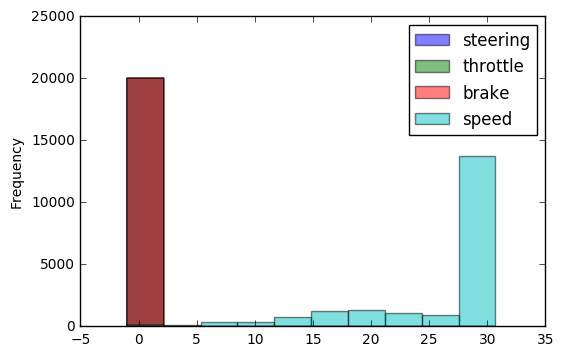

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
dataset.df.plot.hist(alpha=0.5)

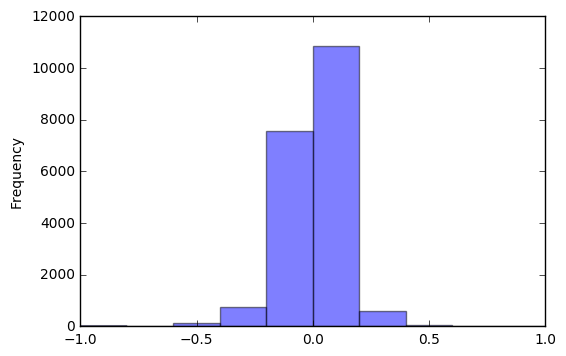

In [5]:
dataset.df['steering'].plot.hist(alpha=0.5)

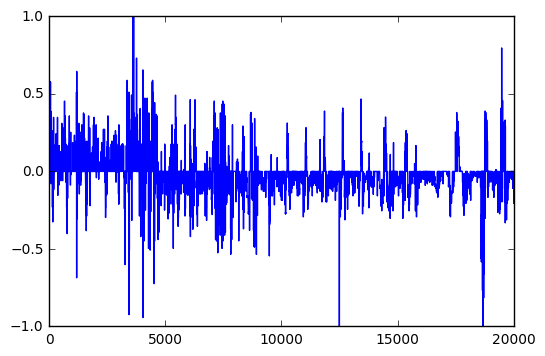

In [6]:
dataset.df['steering'].plot()

Explore the features

In [7]:
perm = np.arange(len(dataset.X_train))
np.random.shuffle(perm)        
generator = dataset.batch_generator(X=dataset.X_train[perm[0:10]], Y=dataset.y_train[perm[0:10]], output_shape=(40, 80, 3), label='batch feature exploration', num_epochs=1, batch_size=32)

Batch generating against the batch feature exploration dataset with population 10 and shape (10,)
batch gen iter 1
  sampled entire population. reshuffling deck and resetting all counters.
L3 - real:-0.06076008826494217 - aug:-0.09114013239741325 - CENTER 1.5x
C1 - 0.0 - CENTER
L2 - real:-0.01234566979110241 - aug:-0.02469133958220482 - LEFT 2x
L1 - real:-0.06076008826494217 - aug:-0.1822802647948265 - LEFT 3x
L3 - real:-0.022028550505638123 - aug:-0.033042825758457184 - CENTER 1.5x
L1 - real:-0.19632050395011902 - aug:-0.5889615118503571 - LEFT 3x
L4 - -0.041394319385290146 - CENTER
C1 - 0.0 - CENTER
R1 - real:0.10917460173368454 - aug:0.3275238052010536 - RIGHT 3x
C1 - 0.0 - CENTER
(10, 40, 80, 3)
(10,)


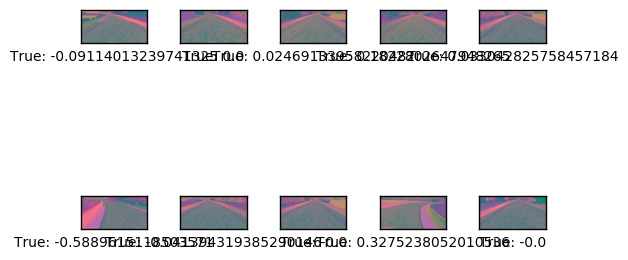

In [8]:
from zimpy.plot.image_plotter import ImagePlotter

X_batch, y_batch = next(generator)
print(X_batch.shape)
print(y_batch.shape)

ImagePlotter.plot_images(X_batch, y_batch, rows=2, columns=5)

#for image in X_batch:
#    plt.imshow(image)

#### Network Architecture

BaseNetwork is the base class for all network implementation. It contains the necessary plumbing to save trained network data, load previously trained model and weights, and implements the abstract #fit method which all sub classes must implement.

In [9]:
class BaseNetwork:
    
    WEIGHTS_FILE_NAME = 'model_final.h5'
    MODEL_FILE_NAME = 'model_final.json'
    
    def __init__(self):
        self.uuid = uuid.uuid4()
        self.model = None
        self.weights = None

    def fit(self, X_train, y_train, X_val, y_val, nb_epoch=2, batch_size=32, samples_per_epoch=None, output_shape=(40, 80, 3)):
        raise NotImplementedError
        
    def get_model(self, input_shape, output_shape, learning_rate=0.001, dropout_prob=0.1, activation='relu'):
        raise NotImplementedError

    def save(self):
        print('Saved {} model.'.format(self.__class__.__name__))
        self.__persist()

    def __persist(self):
        save_dir = os.path.join(os.path.dirname(__file__))
        weights_save_path = os.path.join(save_dir, WEIGHTS_FILE_NAME)
        model_save_path = os.path.join(save_dir, MODEL_FILE_NAME)

        if not os.path.exists(save_dir):
            os.makedirs(save_dir)

        self.model.save_weights(weights_save_ath)
        with open(model_save_path, 'w') as outfile:
            json.dump(self.model.to_json(), outfile)

    def __str__(self):
        results = []
        if self.model is not None:
            results.append(self.model.summary())
        return '\n'.join(results)

Track1 extends BaseNetwork.

It contains a simple 4-layer convolutional neural network with 4 fully connected layers with 10% dropout after flattening the data as well as after the first FC layer.

In [10]:
class Track1(BaseNetwork):
    def fit(self, model, dataset, nb_epoch=2, batch_size=32, samples_per_epoch=None):

        # Fit the model
        # I wrote a custom batch generator with the main goal 
        # of reducing memory footprint on GPU with limited 
        # memory space.
        history = model.fit_generator(
            dataset.batch_generator(
                X=dataset.X_train, 
                Y=dataset.y_train, 
                label='train set', 
                num_epochs=nb_epoch,
                batch_size=batch_size,
                output_shape=output_shape,
                classifier=self
            ),
            nb_epoch=nb_epoch,
            samples_per_epoch=len(X_train),
            verbose=2,
            validation_data=dataset.batch_generator(
                X=dataset.X_val, 
                Y=dataset.y_val,
                label='validation set',
                num_epochs=nb_epoch,
                batch_size=batch_size,
                output_shape=output_shape
            )
        )
        
        print(history.history)
        self.save()
    
    def get_model(self, input_shape, output_shape, learning_rate=0.001, dropout_prob=0.1, activation='relu'):
        """
        Inital zero-mean normalization input layer.
        A 4-layer deep neural network with 4 fully connected layers at the top.
        ReLU activation used on each convolution layer.
        Dropout of 10% (default) used after initially flattening after convolution layers.
        Dropout of 10% (default) used after first fully connected layer.
        
        Adam optimizer with 0.001 learning rate (default) used in this network.
        Mean squared error loss function was used since this is a regression problem and MSE is 
        quite common and robust for regression analysis.
        """
        model = Sequential()
        model.add(Lambda(lambda x: x / 255 - 0.5,
                         input_shape=input_shape,
                         output_shape=output_shape))
        model.add(Convolution2D(24, 5, 5, border_mode='valid', activation=activation))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Convolution2D(36, 5, 5, border_mode='valid', activation=activation))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Convolution2D(48, 5, 5, border_mode='same', activation=activation))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Convolution2D(64, 3, 3, border_mode='same', activation=activation))
        model.add(Flatten())
        model.add(Dropout(dropout_prob))
        model.add(Dense(1024, activation=activation))
        model.add(Dropout(dropout_prob))
        model.add(Dense(100, activation=activation))
        model.add(Dense(50, activation=activation))
        model.add(Dense(10, activation=activation))
        model.add(Dense(1, init='normal'))

        optimizer = Adam(lr=learning_rate)
        model.compile(loss='mse', optimizer=optimizer, metrics=['accuracy'])
        self.model = model
        model.summary()
        return model

#### Instantiate the classifier

In [11]:
output_shape=(40, 80, 3)

clf = Track1()
model = clf.get_model(
    input_shape=output_shape, 
    output_shape=output_shape, 
    learning_rate=0.001, 
    dropout_prob=0.1, 
    activation='relu'
)

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 40, 80, 3)     0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 36, 76, 24)    1824        lambda_1[0][0]                   
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 18, 38, 24)    0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 14, 34, 36)    21636       maxpooling2d_1[0][0]             
___________________________________________________________________________________________

#### Train the network

In [12]:
if False:
    clf.fit(
        model, 
        dataset, 
        nb_epoch=2, 
        batch_size=32
    )